In [47]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime

In [48]:
% pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

Populating the interactive namespace from numpy and matplotlib


In [49]:
import matplotlib.pyplot as plt

In [50]:
data = pd.read_csv("NSE_2000_2018.csv")

In [51]:
data.head()

Unnamed: 0         Date     Open     High      Low   Close  Shares Traded  \
0           0  03-Jan-2000  1482.15  1592.90  1482.15  1592.2       25358322   
1           1  04-Jan-2000  1594.40  1641.95  1594.40  1638.7       38787872   
2           2  05-Jan-2000  1634.55  1635.50  1555.05  1595.8       62153431   
3           3  06-Jan-2000  1595.80  1639.00  1595.80  1617.6       51272875   
4           4  07-Jan-2000  1616.60  1628.25  1597.20  1613.3       54315945   

   Turnover (Rs. Cr)  
0             884.15  
1            1973.69  
2            3084.79  
3            2531.18  
4            1914.63

In [52]:
data.shape

(4526, 8)

In [9]:
# Getting Stock Prices

In [53]:
index_open  = list(data['Open'])

In [54]:
dates = data['Date']

In [55]:
stock_price = pd.Series(index_open,index=dates)

In [56]:
stock_price.head()

Date
03-Jan-2000    1482.15
04-Jan-2000    1594.40
05-Jan-2000    1634.55
06-Jan-2000    1595.80
07-Jan-2000    1616.60
dtype: float64

In [57]:
stock_price.shape

(4526,)

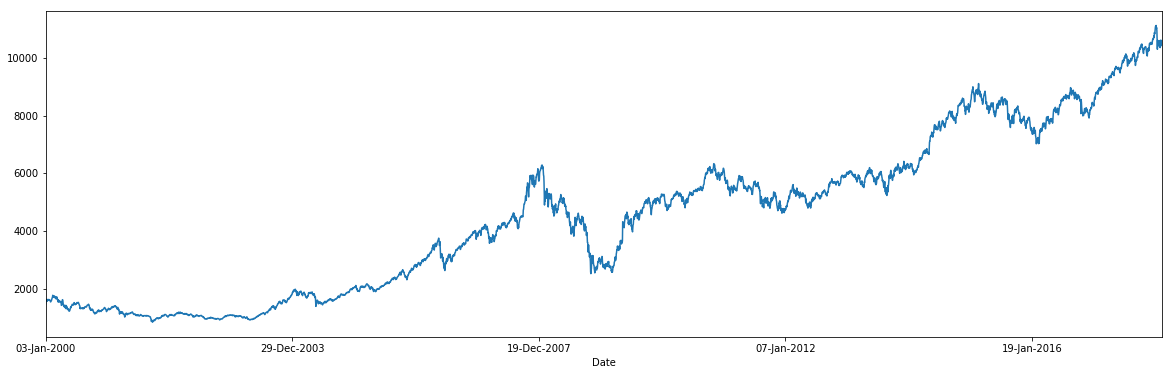

In [58]:
stock_price.plot()

# Model - Convolution1D with Max Pooling Layer

# Converting into supervised Problem

In [59]:
def make_timeseries_instances(timeseries, window_size=20):
    """Make input features and prediction targets from a `timeseries` for use in machine learning.
    
    Return
    
    A tuple of `(X, y, q)`.  `X` are the inputs to a predictor, a 3D ndarray with shape
      ``(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)``.  
      For each row of `X`, the corresponding row of `y` is the next value in the timeseries.  The `q` or query is the last instance, what you would use
      to predict a hypothetical next (unprovided) value in the `timeseries`.
      
     Parameters 
     
     1. ndarray timeseries: Either a simple vector, or a matrix of shape ``(timestep, series_num)``, i.e., time is axis 0 (the
      row) and the series is axis 1 (the column).
     2. int window_size: The number of samples to use as input prediction features (also called the lag or lookback).
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [64]:
a = make_timeseries_instances(range(100))

In [69]:
a[2].shape

(1, 20, 1)

# Building Model - 1DConvolution with MaxPooling

In [78]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential

In [108]:
def make_timeseries_regressor(window_size, filter_length=5, nb_input_series=1, nb_outputs=1, nb_filter=4):
    """:Return: a Keras Model for predicting the next value in a timeseries given a lookback window.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    
    Parameters
    1. int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    2. int nb_input_series: The number of input timeseries; 1 for a single timeseries.
    3. int nb_outputs: The output dimension, often equal to the number of inputs.
    
    Convolutional Parameters 
    1. int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. 
     2. int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
     
    
      Input and Output values   
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; 
      each instance is a 2D array of shape ``(window_size, nb_input_series)``.  
      For example, for `window_size` = 3 and `nb_input_series` = 1 (asingle timeseries), one instance  ``[[0], [1], [2]]``.

      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Conv1D(activation="relu", input_shape=(window_size, nb_input_series), filters=nb_filter, kernel_size=filter_length),
        MaxPooling1D(),     # Downsample the output of convolution by 2X. 
        Conv1D(activation="relu", filters=(nb_filter*2), kernel_size=int(filter_length/2)),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [109]:
def evaluate_timeseries(timeseries, window_size=20,filter_length = 5,nb_filter = 4,test_ratio=0.30,num_epoch=30, b_size=2):
    """Create a 1D CNN regressor to predict the next value in a `timeseries` using the preceding `window_size` elements
    as input features and evaluate its performance.
    
    Parameters
    
    1. ndarray timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
    2. int window_size: The number of previous timeseries values to use to predict the next.
    3. int filter_length - Conv Model Parameter 
    4. int nb_filter - Conv Model Parameter
    5. num_epoch - Number of Epochs Model is trained 
    6. b_size - batch size during training the parameters
    7. test_ratio - percentage of data considered for testing 
    """
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print '\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries
    
    # Defining Model Parameters
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    print'\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length)
    model.summary() # Printing Model Summary

    X, y, q = make_timeseries_instances(timeseries, window_size) # Input Preparation
    print'\n\nInput features size:', X.shape, '\n\nOutput labels size:', y.shape, '\n\nQuery vector:', q.shape
    
    # Test - Train Split 
    test_size = int(test_ratio * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=num_epoch, batch_size=b_size, validation_data=(X_test, y_test))

    pred = model.predict(X_test)
    result = {}
    result['model'] = model
    result['input_data'] = X,y
    result['train_data'] = {'X_train':X_train,'y_train' : y_train}
    result['test_data'] = {'X_test' : X_test, 'y_test' : y_test}
    result['input_timeseries'] = timeseries
    result['test_input'] = y_test
    result['predictions'] = pred
    return result

In [107]:
results = evaluate_timeseries(stock_price,window_size=20,num_epoch=30)



Timeseries (4526 samples by 1 series):
[[  1482.15]
 [  1594.4 ]
 [  1634.55]
 ..., 
 [ 10488.95]
 [ 10479.95]
 [ 10428.3 ]]


Model with input size (None, 20, 1), output size (None, 1), 4 conv filters of length 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 8, 4)              0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 7, 4)              36        
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 3, 4)              0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 12)                0         
__________________________________________________________

In [91]:
results.keys()

['test_input',
 'predictions',
 'input_data',
 'test_data',
 'input_timeseries',
 'model',
 'train_data']

#   Accuracy and Error Analysis 

# MAE 

In [36]:
mae = np.sum(np.absolute(actual -predicted))/len(actual)

In [119]:
mae

91.801401730609797

In [123]:
avg_index_value = np.mean(actual)

In [124]:
avg_index_value

7819.9956890198955

In [125]:
(mae/avg_value) * 100

1.1739316155827133

In [126]:
mae_average = (np.absolute(actual -predicted)/actual)*100

In [127]:
len(mae_average)

1357

In [128]:
pd.Series(mae_average).describe()

count    1357.000000
mean        1.189961
std         0.895777
min         0.000726
25%         0.528510
50%         1.047086
75%         1.629210
max         6.168792
dtype: float64

In [129]:
len(mae_average[mae_average >2.0])

209

In [130]:
len(mae_average[mae_average >2.0])/float(len(mae_average))

0.15401621223286663

In [134]:
# Test Dates - 
test_date = dates[-1357:]

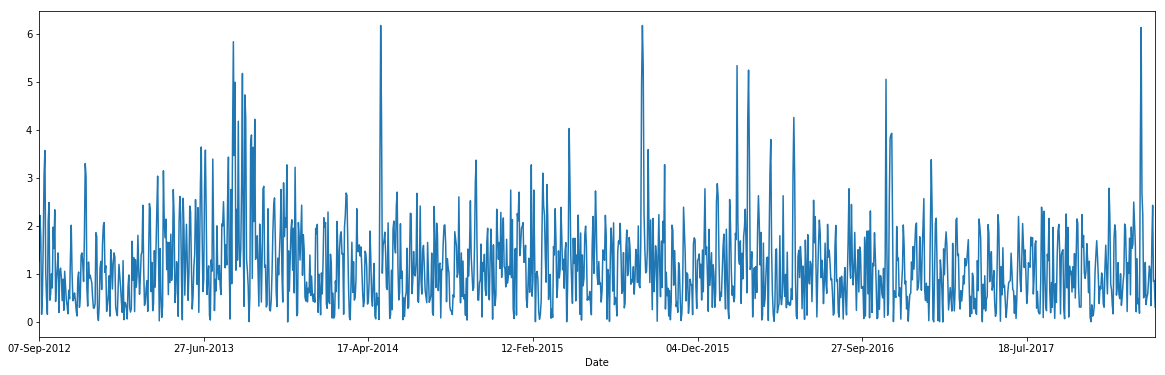

In [140]:
pd.Series(mae_average,index=test_date).plot()

# Plotting Actual and Predicted in Same Graph¶

In [146]:
actual_predicted = pd.DataFrame({'Acutal':list(actual),'Predicted':list(predicted)},index=test_date)

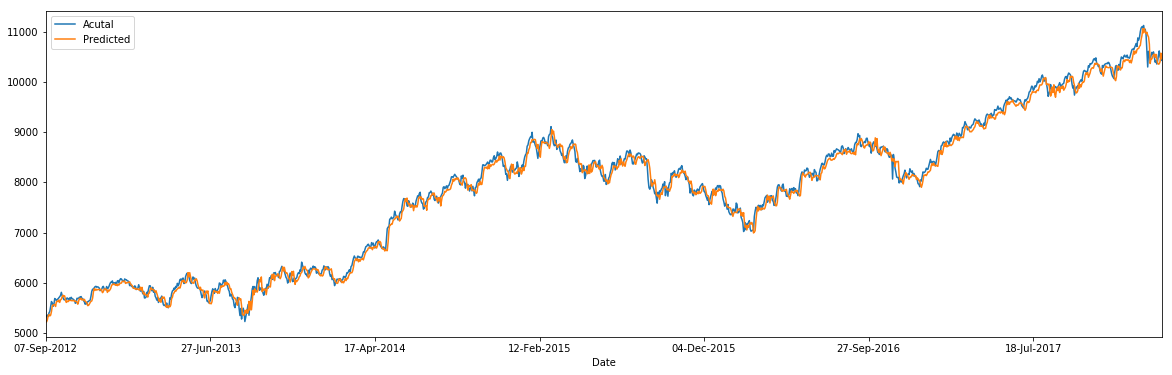

In [147]:
actual_predicted.plot()

# Scatter Plot 

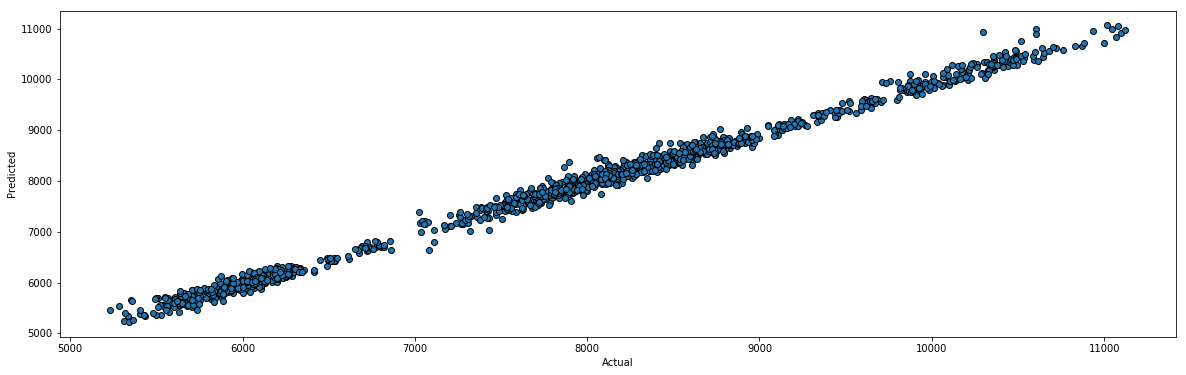

In [143]:
fig, ax = plt.subplots()
ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()